# Image Classifier with Fast.ai Default Settings

This model was adapted from lesson 2 of Fast.ai's course [Practical Deep Learning for Coders, v3](https://course.fast.ai/).

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash
!pip install google_images_download
!wget https://chromedriver.storage.googleapis.com/2.42/chromedriver_linux64.zip  && unzip chromedriver_linux64

Updating fastai...
Done.
--2019-09-28 03:58:31--  https://chromedriver.storage.googleapis.com/2.42/chromedriver_linux64.zip
Resolving chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)... 74.125.201.128, 2607:f8b0:4001:c01::80
Connecting to chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4039043 (3.9M) [application/zip]
Saving to: ‘chromedriver_linux64.zip.2’

chromedriver_linux6 100%[===================>]   3.85M  --.-KB/s    in 0.02s   

2019-09-28 03:58:31 (155 MB/s) - ‘chromedriver_linux64.zip.2’ saved [4039043/4039043]

Archive:  chromedriver_linux64.zip
replace chromedriver? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: chromedriver            


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import json

from fastai.vision import *
from google_images_download import google_images_download

## Downloading Images

The [google-images-download](https://github.com/hardikvasa/google-images-download) script was used to download around 3000 images, around 1500 for each class. Unfortunately, this was done on Colab so the data does not persist. A smarter choice would have been to download the images locally and then upload a zip file of the images.

In [0]:
def download_config(kwrds, time_min, time_max):
    chromedriver_path = '/content/chromedriver/chromedriver'
    time_range = {"time_min": time_min, "time_max": time_max}
    return {
        "keywords" : kwrds,
        "limit" : 100,
        "chromedriver": chromedriver_path,
        "color_type" : "full-color",
        "size": "medium",
        "time_range": json.dumps(time_range)
    }


response  = google_images_download.googleimagesdownload()
for animal in ['alpaca', 'llama']:
    for year in range(2015, 2020):
        for month in range(1, 12, 4):
             time_min = f'{str(month).zfill(2)}/01/{year}'
             time_max = f'{str(month+3).zfill(2)}/31/{year}'
             response.download(download_config(animal, time_min, time_max))


Item no.: 1 --> Item name = alpaca
Evaluating...
Starting Download...
Completed Image ====> 1.Meet-Andre-Page-648x8641.jpg
Completed Image ====> 2.lifebuzz-542e07c904982662318e5a45aed92540-limit_2000.jpg
Completed Image ====> 3.AL-Alma-001.jpg
Completed Image ====> 4.Cassiel_Alpaca_for_Sale_5.JPG
Completed Image ====> 5.crystal-lake-alpaca-boutique.jpg
Completed Image ====> 6.2015_635597945423254356.jpg
Completed Image ====> 7.TAG_Final-5.jpg
Completed Image ====> 8.e653-813295-kendall-creek-2.jpg
Completed Image ====> 9.SilverTitan_Barbicus_703x450_12Apr14_17-700x450.jpg
Completed Image ====> 10.Alpaca-farm.jpg
Completed Image ====> 11.crystal-lake-alpaca-boutique.jpg
Completed Image ====> 12.2015_635642925884431112.jpg
Completed Image ====> 13.enterprise-alpaca-attraction.jpg
Completed Image ====> 14.2015_635628984740946215.jpg
Completed Image ====> 15.46861.jpg
URLError on an image...trying next one... Error: HTTP Error 403: Forbidden
Completed Image ====> 16.Alpaca_Suri.jpg
Comple

In [0]:
path = Path('downloads')
classes = ['alpaca', 'llama']
for c in classes:
    print(c)
    verify_images(path/c, delete=True)

`ImageDataBunch` is a fastai class that splits our dataset into a training and validation sets as PyTorch `DataLoader` objects. We also set data augmentation and normalization using the standard deviation and mean of the ImageNet dataset. The data augmentation settings are the defaults that can be found in the fastai documentation.

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['alpaca', 'llama']

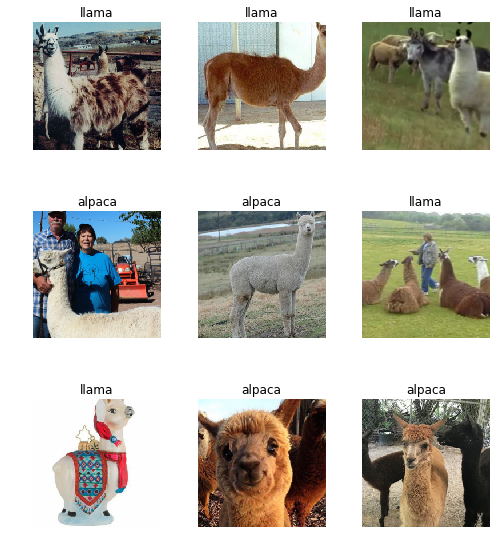

In [0]:
data.show_batch(rows=3, figsize=(7, 8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['alpaca', 'llama'], 2, 2128, 532)

## Training

We will fine-tune a ResNet34 architecture pre-trained on ImageNet. ImageNet contains a "llama" class but no "alpaca" class, so simply using the bottleneck features should not give as good results as a cats vs dogs classifier, but we will use it as our baseline.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 69809294.31it/s]


Fastai provides a method for training using Leslie Smith's [One Cycle Policy](https://arxiv.org/abs/1803.09820). This learning rate scheduling technique builds on previous work on cyclical learning rates, but using only one cycle. The idea is to go from a lower learning rate to a higher rate, then back down to a lower rate in roughly the same amount of steps, with the higher learning rate acting as a regularization method by avoiding steep areas of loss. Combined with cyclic momentum (decreasing the momentum as learning rate increases and vice versa), one cycle policy enables usage of higher learning rates and faster convergence.

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.622229,0.439365,0.159774,01:09
1,0.509646,0.382730,0.154135,01:07
2,0.446338,0.359950,0.139098,01:07
3,0.395522,0.351026,0.146617,01:07


In [0]:
learn.save('stage-1')

We achieved an error rate of 14-15%. We can try to improve this by fine-tuning our model. By default, the pre-trained model is frozen so the convolutional base layers will not change their parameters during training. The features learned by low-level convolutional layers are more general and so we do not want to change them as much. However, we can unfreeze all the layers because we are using one cycle policy, so the earlier layers will not change as much as the deeper layers. 

In [0]:
learn.unfreeze()

We will use a learning rate finder to choose an optimal learning rate range, which is a technique also developed by Leslie Smith. The learning rate is exponentially increased and then plotted against its corresponding loss as the model is trained for a few iterations. Intuitively, the optimal learning rate is the range with the sharpest decrease in loss. A small decrease is a sign that the learning rate is too small, while a lack of direction is a sign that the learning rate is too large.

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


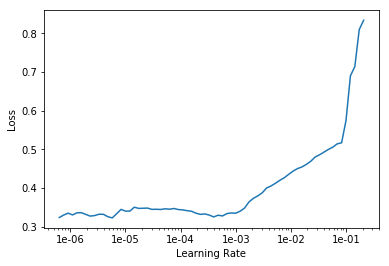

In [0]:
learn.recorder.plot()

Unfortunately, there we did not see the usual sharp decrease in loss. However, the range between 3e-5 and 3e-4 is the only area that really corresponds to a loss decrease, so that is the range that will be used.

In [0]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.356157,0.343215,0.133459,01:09
1,0.298425,0.331700,0.127820,01:09


In [0]:
learn.save('stage-2')

Our validation error rate improved to 12-13%. From the confusion matrix below, we see that our model appears to below similarly on both classes (although we do not see the confidence with which it predicts the classes).

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

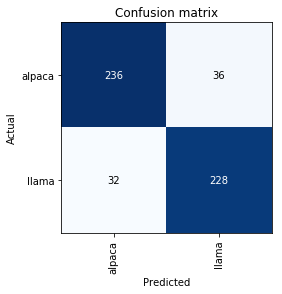

In [0]:
interp.plot_confusion_matrix()

## Example Predictions

In [0]:
from google.colab import files
files.upload()

alpaca: 63.90%


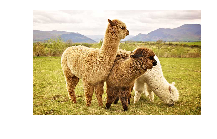

In [0]:
img = open_image('/content/alpaca_example.jpeg')
pred_class, pred_idx, outputs = learn.predict(img)
img.show()
print('{}: {:.2f}%'.format(pred_class, max(outputs) * 100))

llama: 98.95%


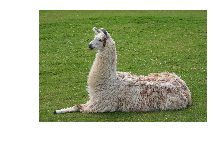

In [0]:
img = open_image('/content/Llama_example.jpg')
pred_class, pred_idx, outputs = learn.predict(img)
img.show()
print('{}: {:.2f}%'.format(pred_class, max(outputs) * 100))

## Conclusion

Unfortunately, a test set was not used, but this study was not rigorous anyways. A validation error rate of 12-13% is pretty good considering how similar alpacas and llamas look. One thing that can be improved on is the quality of the dataset. While more data was used for this data, the quality of the data was not checked (already when previewing the dataset we saw an example of a llama ornament rather a live animal).